## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt

## Entendendo os dados originais da Rossmann


##### **0. store**:
- um ID exclusivo para cada loja

##### **1. day_of_week**:
- dia da semana em que a venda ocorreu (dados não descritos)

##### **2. date**:
- data de venda (dados não descritos)

##### **3. sales**:
- o volume de negócios para um determinado dia (isto é o que você está prevendo) 

##### **4. customers**:
- o número de clientes em um determinado dia  

##### **5. open**: 
- um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto  

##### **6.  promo**:
- indica se uma loja está realizando uma promoção naquele dia

##### **7. state_holiday**:
- indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum

##### **8. school_holiday**:
- indica se o (store, date) foi afetado pelo fechamento das escolas públicas

##### **9. store_type**:
- diferencia entre 4 modelos de loja diferentes: a, b, c, d

##### **10. assortment**: 
- descreve um nível de sortimento (tipo de produto que tem na loja): a = básico, b = extra, c = estendido

##### **11. competition_distance**:
- distância em metros até a loja concorrente mais próxima

##### **12. competition_open_since_month**:
- fornece o mês aproximado em que o concorrente mais próximo foi aberto

##### **13. competition_open_since_year**:
- fornece o ano aproximado em que o concorrente mais próximo foi aberto

##### **14 . promo2**:
- promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

##### **15. promo2_since_week**:
- descreve a semana em que a loja começou a participar da 'promo2'

##### **16. promo2_since_year**:
- descreve o ano em que a loja começou a participar da 'promo2'

##### **17.  promo_interval**:
- meses em que a promo2 ficou ativa

## Carregamento dos dados

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge (unindo os arquivos csv)
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## Descrição dos dados

### 1. Renomeando colunas

In [3]:
# criando uma cópia do dataset para trabalhar com os dados
df1 = df_raw.copy()

In [4]:
# nomes das colunas antigas
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
cols_originais = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
                  'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                  'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


# criando função para modificar os nomes
def snakecase(x):
    return inflection.underscore(x)


# salvando colunas novas e aplicando a função anterior utilizando o map
cols_novas = list(map(snakecase, cols_originais))

# renomeando
df1.columns = cols_novas

In [6]:
# checando modificação nos nomes das colunas

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 2. Verificando a dimensão dos dados

In [7]:
print(f'Linhas: {df1.shape[0]}')
print(f'Colunas: {df1.shape[1]}')

Linhas: 1017209
Colunas: 18


### 3. Verificando os tipos de dados

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# coluna 'date' de object para datetime
df1['date'] = pd.to_datetime(df1['date'])

In [10]:
# checando modificações
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 4. Checando dados nulos (NA)

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 5. Substituindo as colunas que possuem dados nulos

##### **comptetition_distance**:
- distância em metros do competidor mais próximo
- sugestão: substituir os dados nulos por um número acima do valor máximo de distância, pois ou não há competidor ou está longe o suficiente para não ser considerado um

##### **competition_open_since_month**:
- mês que o competidor mais próximo foi aberto
- sugestão: substituir os dados nulos do mês de abertura pelo mês da data de venda registrada (coluna 'date') na linha

##### **competition_open_since_year**:
- ano que o competidor mais pŕoximo foi aberto
- sugestão: substituir os dados nulos do ano de abertura pelo ano da data de venda registrada (coluna 'date') na linha

##### **OBSERVAÇÃO**:
- coluna promo2: significa continuação de uma promoção, 0 -  não está participando; 1- está participando
- as colunas seguintes dependem dessa
- importante: sempre onde a promo2 é 0, os dados seguintes são nulos, ou seja, apenas significam que não houve promo2

##### **promo2_since_week**:
- semana em que a loja começou a participar da promo2
- sugestão: substituir os dados nulos extraindo a semana da data de venda registrada (coluna 'date')

##### **promo2_since_year**:
- ano em que a loja começou a participar da promo2
- sugestão:substituir os dados nulos extraindo o ano da data de venda registrada (coluna 'date')

##### **promo_interval**:
- meses em que a promo2 ficou ativa

- sugestão 1: substituir dados nulos da 'promo_interval' por 0

- sugestão 2 ['month_map']: adicionar meses na coluna nova 'month_map' de acordo com o mês presente na coluna de data de venda 'date'

- sugestão 3 ['is_promo']: se o mês 'month_map' estiver dentro da lista presente em 'promo_interval', adicionar: 1-tem promoção; 0-não tem promoção.

In [12]:
# visualização da matriz transposta

df1.T

,0,1,2,3,4,5,6,7,8,9,...,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
store,1,2,3,4,5,6,7,8,9,10,...,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
day_of_week,5,5,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,...,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,...,0,0,0,0,0,0,0,0,0,0
customers,555,625,821,1498,559,589,1414,833,687,681,...,0,0,0,0,0,0,0,0,0,0
open,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
promo,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
state_holiday,0,0,0,0,0,0,0,0,0,0,...,a,a,a,a,a,a,a,a,a,a
school_holiday,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
store_type,c,a,a,c,a,a,a,a,a,a,...,a,a,a,c,c,a,c,a,a,d


In [13]:
# encontrando o valor máximo para utilizar de parâmetro para a 'competition_distance'
df1['competition_distance'].max()

75860.0

In [14]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 if math.isnan(x) else x)

In [15]:
# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(
    x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [16]:
# competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [17]:
# promo2_since_week

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(
    x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [18]:
# promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [19]:
# promo_interval

# criando dicionario com os meses
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# sugestão 1: se for nan, vai substituir por 0
df1['promo_interval'].fillna(0, inplace=True)

# sugestão 2: ['month_map']
df1['month_map'] = df1['date'].dt.month.map(month_map)

# sugestão 3: ['is_promo']
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [20]:
# checando o tratamento de NA

df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [21]:
# checando os tipos de dados

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 6. Verificando e convertendo os tipos de dados

In [22]:
# convertendo colunas para int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
    int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [23]:
# checando a conversão

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 7. Análises estatísticas

In [24]:
# separando colunas com dados numéricos
colunas_numericas = df1.select_dtypes(include=['int64', 'float64'])

# separando colunas com dados categóricos
colunas_categoricas = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

#### 7.1 Dados numéricos

In [25]:
# transpondo métricas de tendência central (média, mediana)

tc1 = pd.DataFrame(colunas_numericas.apply(np.mean)).T
tc2 = pd.DataFrame(colunas_numericas.apply(np.median)).T

# transpondo métricas de dispersãpo (desvio padrão, min, max, range, skew, kurtosis)

md1 = pd.DataFrame(colunas_numericas.apply(np.std)).T
md2 = pd.DataFrame(colunas_numericas.apply(min)).T
md3 = pd.DataFrame(colunas_numericas.apply(max)).T
md4 = pd.DataFrame(colunas_numericas.apply(lambda x: x.max() - x.min())).T
md5 = pd.DataFrame(colunas_numericas.apply(lambda x: x.skew())).T
md6 = pd.DataFrame(colunas_numericas.apply(lambda x: x.kurtosis())).T

# concatenando dados na ordem de visualização
metricas = pd.concat([md2, md3, md4, tc1, tc2, md1, md5, md6]).T.reset_index()

# nomeando colunas
metricas.columns = ['features', 'min', 'max', 'range',
                    'mean', 'median', 'std', 'skew', 'kurtosis']

# exibindo as métricas
metricas

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [26]:
# selecionando o tema do gráfico
sns.set_theme(style='darkgrid')

<AxesSubplot: xlabel='competition_distance', ylabel='Count'>

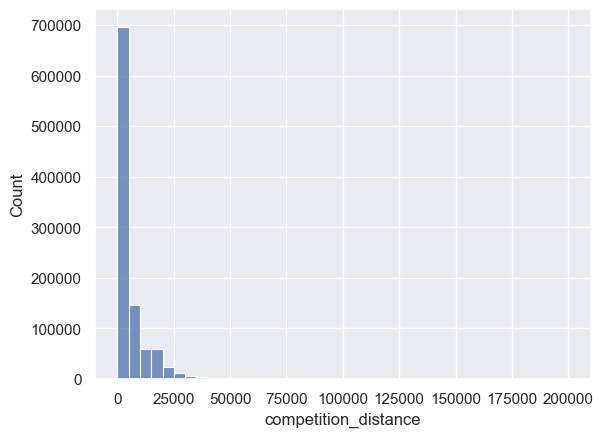

In [27]:
# verificando distribuição de distância dos concorrentes
sns.histplot(df1['competition_distance'], bins=40)

#### 7.2 Dados categóricos

In [28]:
# valores únicos dos dados categóricos
colunas_categoricas.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

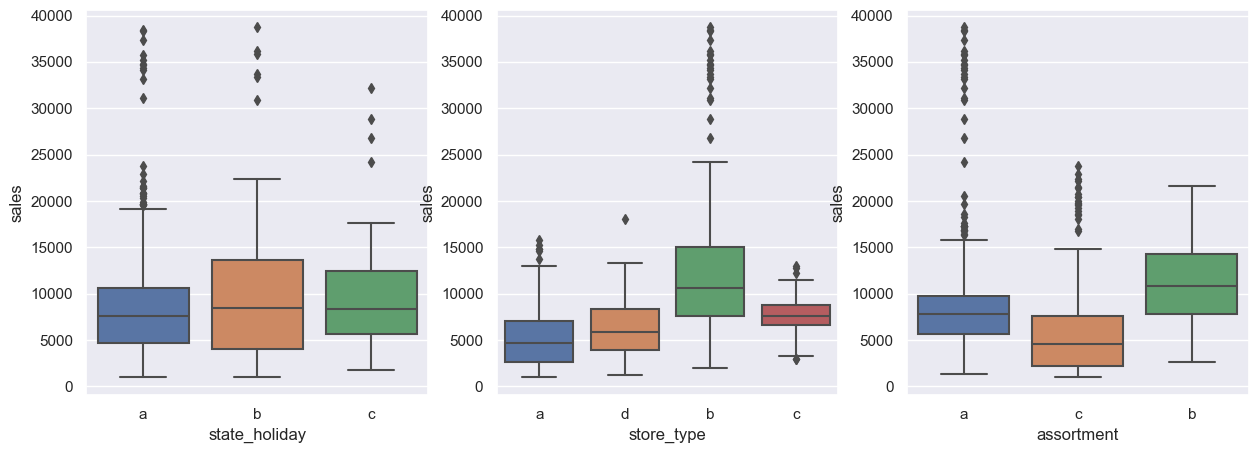

In [29]:
# criando um filtro de linhas
filtro = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# noção das vendas distribuídas nos níveis das variáveis categóricas

plt.figure(figsize = (15,5))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=filtro)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=filtro)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=filtro)